# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

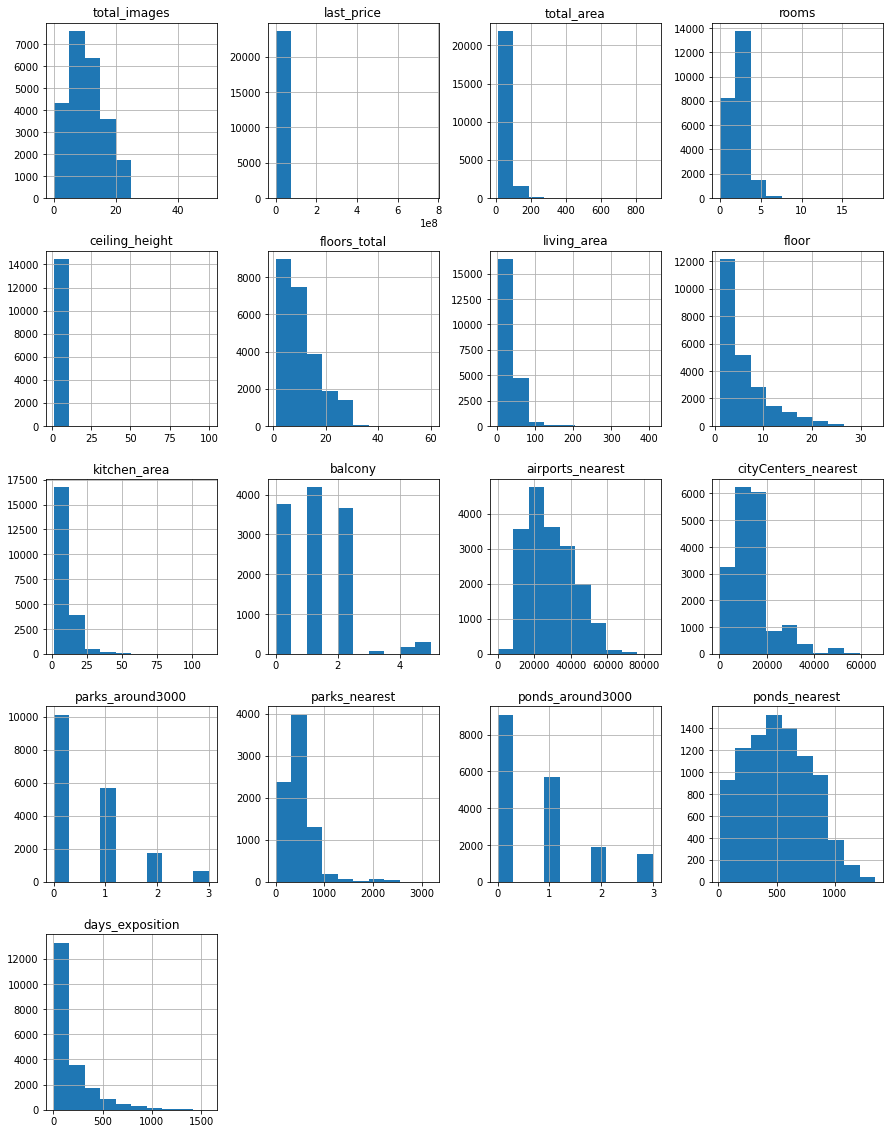

In [14]:
import pandas as pd
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
print(data.head(15))
data.hist(figsize=(15, 20))

### Предобработка данных

In [15]:

data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())
data['balcony']=data['balcony'].fillna(0)
data['is_apartment']=data['is_apartment'].fillna('False')
data['floors_total']=data['floors_total'].fillna(data['floor'])

data=data.dropna(subset=['locality_name'])
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())

#изменила формулы для заполнения пропусков на расчет с применением соотношения медиан соответствующих столбцов
data['living_area']=data['living_area'].fillna(data['total_area']*(data['living_area']).median()/data['total_area'].median())
data['kitchen_area']=data['kitchen_area'].fillna(data['total_area']*(data['kitchen_area']).median()/data['total_area'].median())

print(data.loc[(data['days_exposition'].isna())&(data['first_day_exposition']<'2018-01-01T00:00:00')].head(20))

print(data.info())

     total_images  last_price  total_area first_day_exposition  rooms  \
52             20  11795000.0      136.00  2017-09-22T00:00:00      6   
108             9   9490000.0       80.00  2017-10-30T00:00:00      3   
173            15  11000000.0       97.90  2017-04-11T00:00:00      3   
181             2   7900000.0       71.80  2017-08-23T00:00:00      3   
223            20   2350000.0       35.40  2017-12-12T00:00:00      1   
233            17  19800000.0      118.00  2017-12-15T00:00:00      3   
259             6    900000.0       30.00  2017-11-21T00:00:00      1   
260             8  17250000.0      102.40  2014-12-09T00:00:00      3   
263            12  39900000.0      140.60  2016-11-19T00:00:00      2   
354            20   7030000.0       42.60  2017-11-20T00:00:00      2   
381            11   2600000.0       86.30  2016-05-24T00:00:00      4   
520            16  11700000.0       68.10  2016-11-02T00:00:00      2   
525             4   3900000.0       35.00  2016-10-

Пропуски в данных могут быть обусловлены ошибками, допущенными при ручном заполнении форм, дефектом самих форм, 
а также ошибками при переносе данных в датасет.

In [16]:
# изменение типов данных по столбцам
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d')

data['is_apartment']= data['is_apartment'].astype('bool')
data[['floors_total','balcony']]=data[['floors_total','balcony']].astype('int')


Произведено изменение  типа данных в столбце 'is_apartment' на булевый, потому что данный столбец является характеристикой помещения (студия или нет).
Также произведено изменение типа данных столбца 'first_day_exposition' на тип данных datetime для дальнейших вычислений.
Также произведено изменений нескольких столбцов на тип данных int, т.к. согласно первичного анализа данных все значения в указанных столбцах были целочисленными.


In [17]:
#устранение неявных дубликатов в столбце 'locality_name'
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской поселок ', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа ', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок станции ', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок ', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок ', '')
data['locality_name'] = data['locality_name'].str.replace('поселок', '')
data['locality_name'] = data['locality_name'].str.replace('деревня ','')
data['locality_name'] = data['locality_name'].str.replace('село ','')

In [18]:
# Код ревьюера
data['locality_name'] = data['locality_name'].str.replace('ё','е')

устранены неявные дубликаты в названиях

In [19]:
#устранение редких и выбивающихся значений
data.loc[data['ceiling_height']>=20, 'ceiling_height']=data['ceiling_height']/10

#печатаю 10 самых частых значений столбца 'days_exposition'
from collections import Counter
print(Counter(data['days_exposition']).most_common(10 ))
#удаляю 2 явных выброса из выборки
data=data.loc[((data['days_exposition']!= 45.00000000000001)&(data['days_exposition']!=60.0))]

print('% остатка базы после удаления выбросов days_exposition', data.count()/23699)
print(data.count())

print(data.describe())
#применяю расчет выбросов по межквартильному интревалу (верхняя граница) к total_area  и last_price
data=data.loc[data['total_area']<=70+1.5*(70-40)]
data=data.loc[data['last_price']<=6900000+1.5*(6900000-3465000)]
print('% остатка базы после удаления выбросов total_area и last_price', data.count()/23699)
print(data.count())

[(45.00000000000001, 879), (60.0, 538), (7.0, 234), (30.0, 208), (90.00000000000001, 203), (4.0, 174), (3.0000000000000004, 158), (5.0, 152), (14.0, 148), (9.0, 142)]
% остатка базы после удаления выбросов days_exposition total_images            0.938141
last_price              0.938141
total_area              0.938141
first_day_exposition    0.938141
rooms                   0.938141
ceiling_height          0.938141
floors_total            0.938141
living_area             0.938141
floor                   0.938141
is_apartment            0.938141
studio                  0.938141
open_plan               0.938141
kitchen_area            0.938141
balcony                 0.938141
locality_name           0.938141
airports_nearest        0.726824
cityCenters_nearest     0.938141
parks_around3000        0.727794
parks_nearest           0.326132
ponds_around3000        0.727794
ponds_nearest           0.365163
days_exposition         0.803958
dtype: float64
total_images            22233
last_pr

<div class="alert alert-block alert-info">
В целях получения данных о межквартирных интервалах по столбцам last_price, total_area и days_exposition я с помощью 
print(data.describe()) вывела указанные параметры столбцов.

После применила к указанным столбцам формулу удаления выбросов:
    
    
data=data.loc[((data['column']<=(Q3+1.5*(Q3-Q1)))&(data['column']>=(Q1-1.5*(Q3-Q1))))]
    
    
в Q3 и Q1 подставила ранее полученные значения из data.describe().

Но к столбцу 'days_exposition' удалось применить только верхнюю границу, т.к при применении нижней обнулялась выборка.

</div>

<div class="alert alert-block alert-info">
<b>Комментарий после второй правки</b>

Вычислила и удалила 2 явных выброса по столбцу days_exposition

После нашла Q3 и Q1 межквартильных интервалов по столбцам last_price, total_area.
Удалила выбросы выше верхней границы по формуле:
    data=data.loc[data['column']<=(Q3+1.5*(Q3-Q1))
                                                  
                                                  
В результате получилась таблица 85% от начальной базы данных, больше исходных данных сохранить не получается, 
т.к. слишком разбросанные диапазоны (и года от 2014 по  2019, и цены от 500 тыс. до 300 млн, 
в результате чего начинают сбиваться последущие расчеты и графики)

</div>

по результатам анализа выбивающихся значений в столбцах 'ceiling_height' и 'last_price' устранены выбивающиеся ошибочные значения (расчет с межквартильным размахом по столбцам 'last_price' и 'days_exposition'). 

Выявленные особенности в данных:
после выполнения операций по удалению дубликатов и выбивающихся значений данные стали более однородными, выборка уменьшилась на 5000 строк.  в выборке присутствуют сильно отличающиеся друг от друга объекты - например площадь объекта варьируется от 12 до 114 кв.м., цена объектов также достаточно различается - от 1,2 млн до 118 млн рублей.

### Посчитайте и добавьте в таблицу новые столбцы

In [20]:
data['price_meter']=round(data['last_price']/data['total_area'],2)
data['weekday']=data['first_day_exposition'].dt.weekday
data['month']=data['first_day_exposition'].dt.month
data['year']=data['first_day_exposition'].dt.year

import numpy as np
conditions = [data['floor']==1,  data['floor']==data['floors_total'], data['floor']<data['floors_total']]
choices = ['первый', 'последний','другой']
data['floor_type'] = np.select (conditions, choices)

data['Center_km']=round(data['cityCenters_nearest']/1000).astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,month,year,floor_type,Center_km
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,13
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,True,...,NaN,0.0,NaN,155.0,99195.71,3,11,2017,другой,19


### Проведите исследовательский анализ данных

array([[<AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'last_price'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'floors_total'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'weekday'}>],
       [<AxesSubplot:title={'center':'month'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

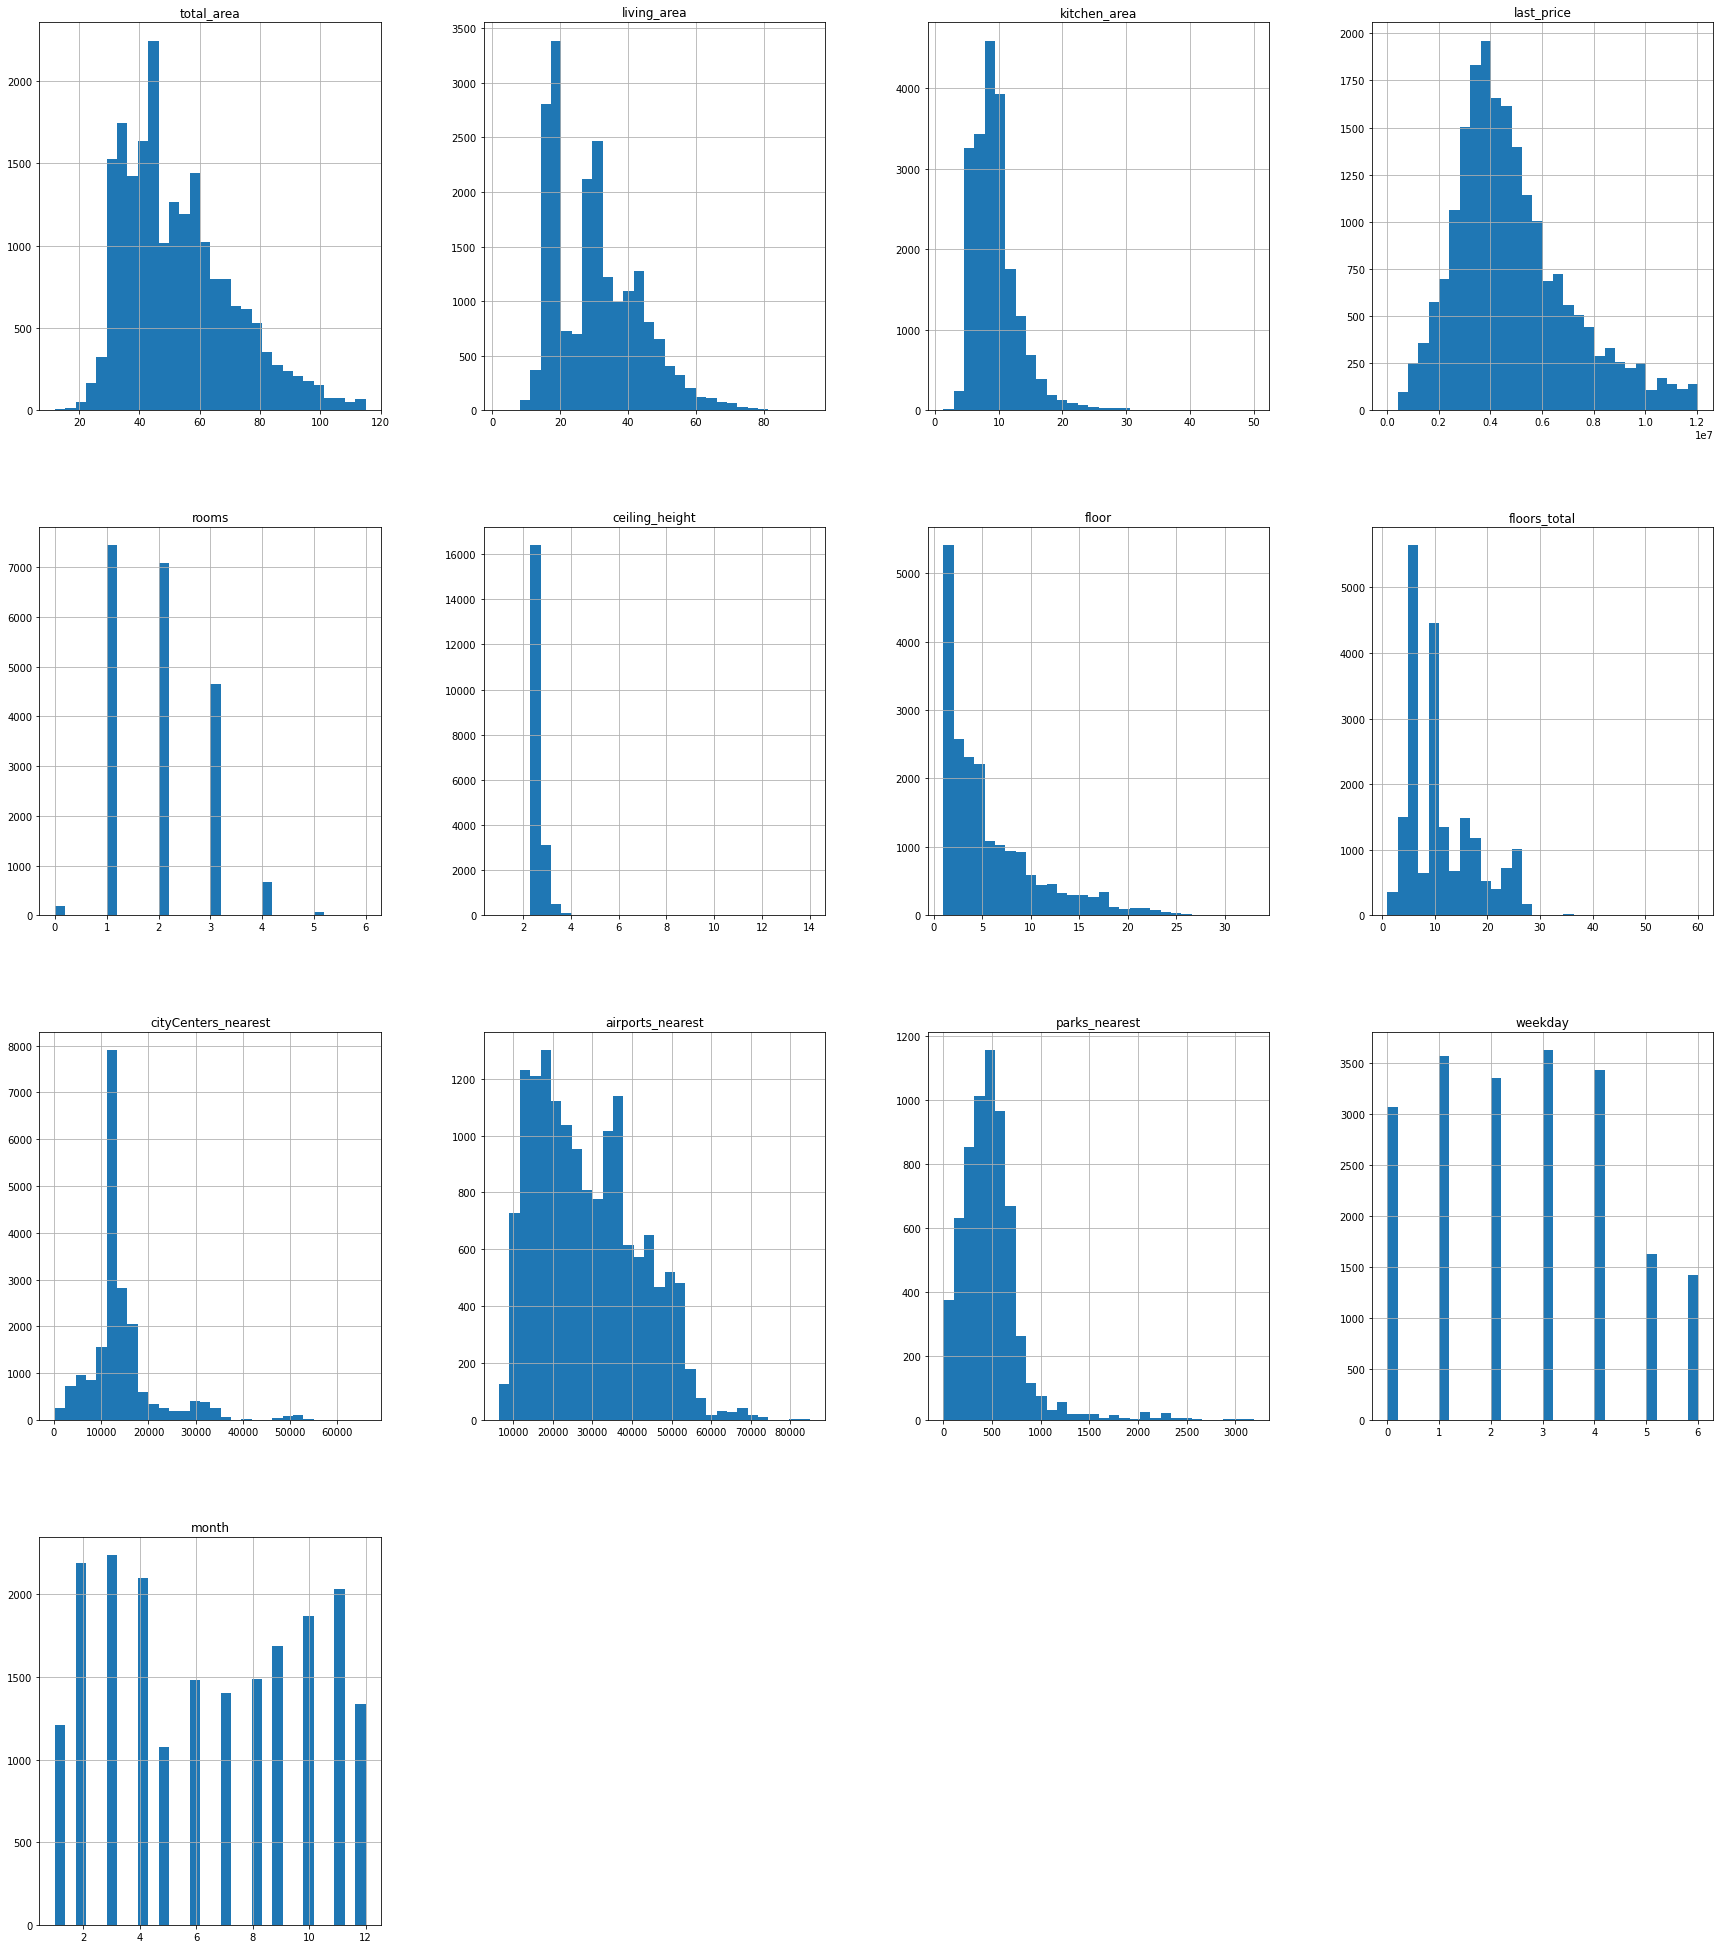

In [21]:
hist_list=['total_area','living_area','kitchen_area','last_price',\
           'rooms','ceiling_height','floor','floor_type', \
           'floors_total','cityCenters_nearest', 'airports_nearest',\
          'parks_nearest', 'weekday', 'month' ]
data[hist_list].hist(figsize=(30, 35), bins=30)

Наблюдения по параметрам гистограмм:
1. общая площадь - основная часть квартир датафрейма имеет площадь от 30 до 60 кв.м. 
2. жилая площадь квартир в основном варьируется от 15 до 50 кв. м.
3. площадь кухни - наиболее часто встречается площадь кухни около 10 кв.м. (стандарт)
4. цена квартиры - основная часть квартир продается в диапазоне 30-50 млн рублей (9 000 вариантов), далее идут цены от 50 до 60 млн рублей (3 000 вариантов)
5. количество комнат - основные варианты - одно и двух комнатные квартиры - более 50 процентов базы, квартир с количеством комнат 3 и 4 значительно меньше
6. высота потолков - абсолютное большинство вариантв имеют стандартную высоту потолка около 3 м.
7. этаж - половина продаваемых квартир находятся на нижних этажах - до пятого.
8. этажность дома - большая часть вариантов находятся в домах этажностью 5-10 этажей.
9. расстояние от центра - основная часть квартир находится в пределах 10 км от центра, далее больше 5000 вариантов  имеют расстояние от 10 до 20 км. от центра
10. расстояние от аэропорта - около половины квартир расположены на расстоянии 20 км от аэропорта, также значительная часть распределена примерно в 10 и 30-40 км от аэропорта, при увеличении расстояния от аэропорта доля квартир снижается.
11. парки рядом - основная масса квартир расположена рядом с парками, около  500 м, редко встречаются варианты до 1 км от парка.
12. дни публикации объявлений  - в основном объявления опубликованы в будние дни, разница между днями не слишком значительна, по понедельникам публикации немного реже. по выходным количество публикаций падает примерно вдвое.


 Медианное значение срока размещения объявления  103.0
 Среднее значение срока размещения объявления  182.01715952639708


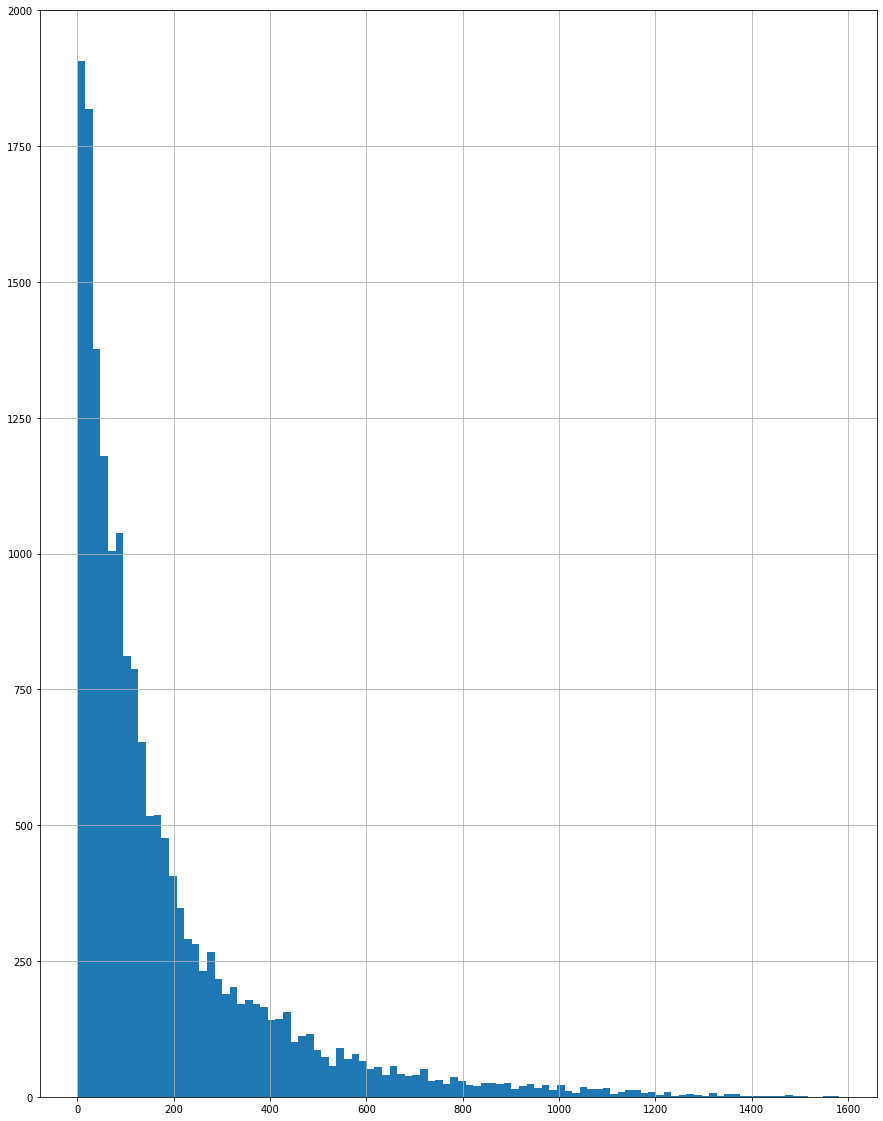

In [22]:
# анализ столбца days_exposition - скорость продажи квартир

data['days_exposition'].hist(figsize=(15, 20), bins=100)
print(' Медианное значение срока размещения объявления ', data['days_exposition'].median() )
print(' Среднее значение срока размещения объявления ', data['days_exposition'].mean() )

Наиболее часто срок размещения объявления до снятия составляет около 30 дней. Медианой является 98 дней, средний срок размещения 
объявления составляет 143 дня.
Быстрой можно считать продажу со сроком размещения до 50 дней, необычно долгой более 200 дней. в базе имеются варианты со сроками продажи более года, что также достаточно редкий случай.


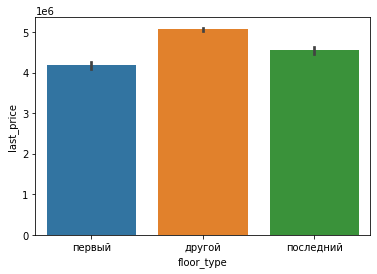

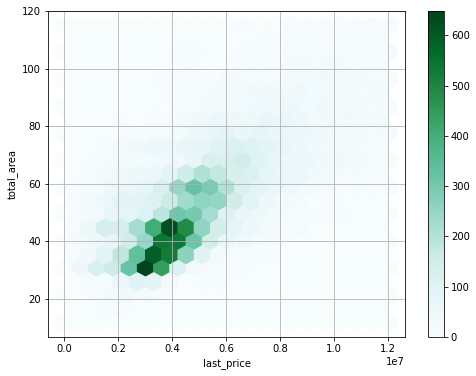

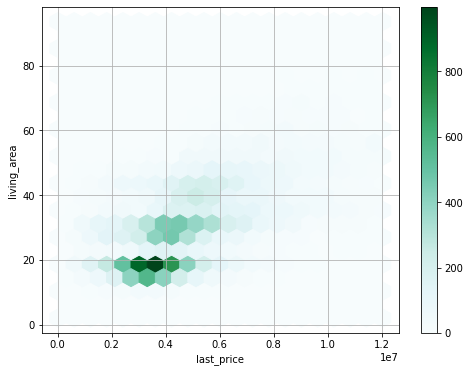

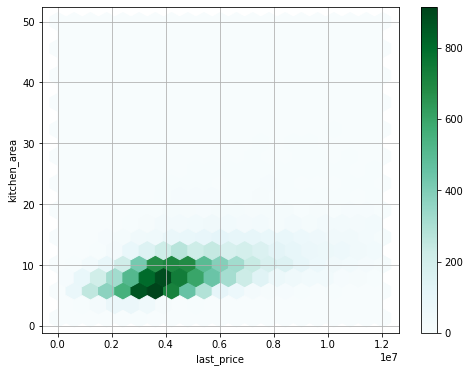

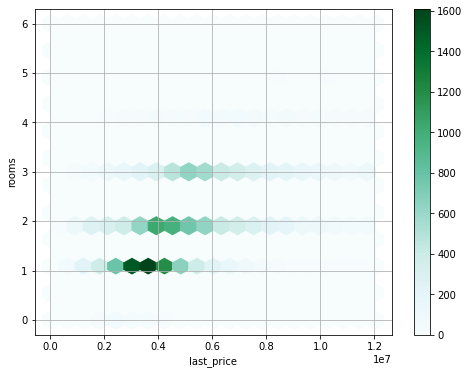

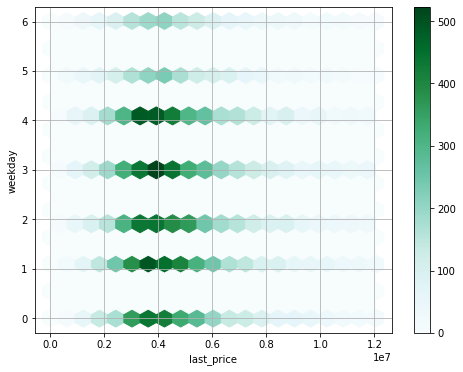

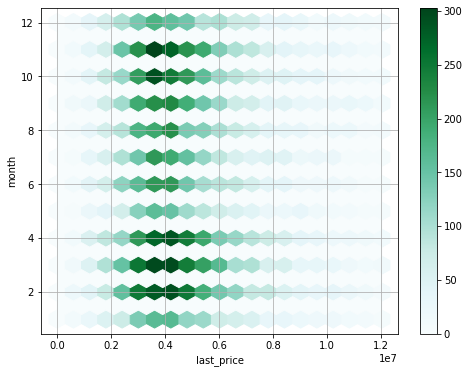

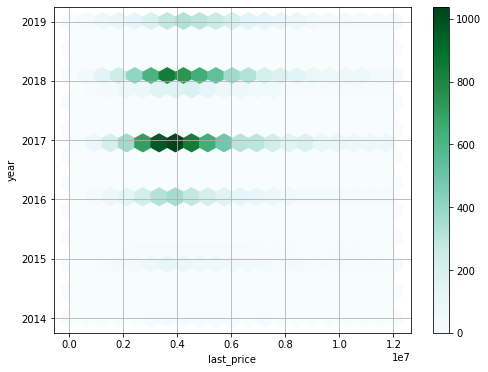

In [23]:
# анализ факторов влияния на стоимость квартиры
import seaborn as sns
sns.barplot(data=data, x='floor_type', y='last_price')
barplot_list = data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday', 'month', 'year']]
for i in barplot_list:
    data.plot(x='last_price', y=i, kind='hexbin', gridsize=20, figsize=(8,6), grid=True, sharex=False)

#data[['last_price', 'weekday', 'month', 'year']].plot(x='last_price', kind='bar')

Согласно графика видна зависимость стоимости квартиры от этажа - стоимость квартир на 1 этаже несколько ниже, чем средних и последних этажей.
БОльшая часть квартир в диапазоне от  30 до 60 кв.м. продается по цене от 20 до 50 млн. руб.
Основная часть квартир с жилой площадью около 20 кв.м. продаются в диапаpоне 20-40 млн. руб.
Квартиры с площадью кухни 8-10 кв.м. продаются в среднем ценовом сегменте от 30 до 50 млн. руб.
Основная стоимость однокомнатных квартир составляет 30-40 млн. руб, двухкомнатных - 40-50 млн. руб., трехкомнатных -50-60 млн. руб.
Наиболее часто объявления о продаже квартир выставляются в базу в будние дни - с понедельника по пятницу, на выходных объявлений значительно меньше.
Наиболее часто продажа квартир происходит весной - с марта по май.
Большая часть объявлений базы данных опубликованы в  2017 и 2018 году.

In [24]:
#расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
data_local=data.pivot_table(index='locality_name', values='price_meter', aggfunc=['mean','count'])
data_local.columns=['mean','count']
data_local.sort_values('count', ascending=False).head(10)

,mean,count
locality_name,,
Санкт-Петербург,106021.843052,13003
Мурино,85961.556877,554
Кудрово,94941.642336,428
Шушары,78898.618015,403
Всеволожск,67086.391671,365
Пушкин,100671.924752,322
Колпино,75499.443432,303
Парголово,90746.307931,290
Гатчина,68421.542872,282


Средняя цена квадратного метра больше всего в Санкт-Петербурге, она составляет 106021.84 руб./кв.м., дешевле всего стоимость квадратного метра в Выборге - 58207.98 руб./кв.м.

<AxesSubplot:xlabel='Center_km'>

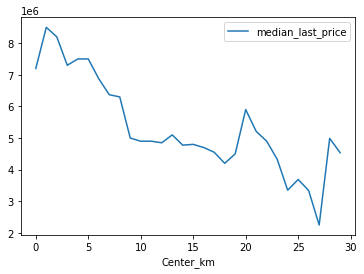

In [25]:
# расчет стоимости километра в Санкт-Петербурге
data_spb=data.loc[data['locality_name']=='Санкт-Петербург', ['last_price', 'Center_km']]
data_spb.columns=['last_price', 'Center_km']
data_spb_pivot=data_spb.pivot_table(index='Center_km', values='last_price', aggfunc=['median'])
data_spb_pivot.columns=['median_last_price']

data_spb_pivot.plot()

Согласно расчетов и графика прослеживается зависимость между расстоянием от центра города и стоимостью объектов недвижимости. Наиболее дорогая недвижимость находится в центра города (расстояние до 5 км). Далее стоимость постепенно снижается.

### Общий вывод

В рамках работы над проектом произведен анализ базы данных объектов недвижимости более 23 000 строк.
В ходе предварительной обработки данных произведен поиск и удаление явных и неявных дубликатов, поиск пропусков, заполнение пропусков подходящими значениями, не искажающими результаты анализа.
Также произведена обработка датафрейма, удаление выбросов в целях корректного анализа данных, устранены явные ошибки.
Также в ходе предварительной обработки данных изменены типы данных нескольких столбцов в целях корректного последующего анализа.
Выявлены основные причины ошибок в данных - они могут быть обусловлены ошибками, допущенными при ручном заполнении форм, дефектом самих форм, а также ошибками при переносе данных в датасет.
После выполнения операций по удалению дубликатов и выбивающихся значений данные стали более однородными, выборка уменьшилась на 5000 строк. в выборке присутствуют сильно отличающиеся друг от друга объекты - например площадь объекта варьируется от 12 до 114 кв.м., цена объектов также достаточно различается - от 1,2 млн до 118 млн рублей.

Далее произведен исследовательский анализ данных.

Наблюдения по параметрам гистограмм:
общая площадь - основная часть квартир датафрейма имеет площадь от 30 до 60 кв.м. 
 жилая площадь квартир в основном варьируется от 15 до 50 кв. м.
площадь кухни - наиболее часто встречается площадь кухни около 10 кв.м. (стандарт)
цена квартиры - основная часть квартир продается в диапазоне 30-50 млн рублей (9 000 вариантов), далее идут цены от 50 до 60 млн рублей (3 000 вариантов)
количество комнат - основные варианты - одно и двух комнатные квартиры - более 50 процентов базы, квартир с количеством комнат 3 и 4 значительно меньше
высота потолков - абсолютное большинство вариантв имеют стандартную высоту потолка около 3 м.
этаж - половина продаваемых квартир находятся на нижних этажах - до пятого.
этажность дома - большая часть вариантов находятся в домах этажностью 5-10 этажей.
расстояние от центра - основная часть квартир находится в пределах 10 км от центра, далее больше 5000 вариантов  имеют расстояние от 10 до 20 км. от центра
расстояние от аэропорта - около половины квартир расположены на расстоянии 20 км от аэропорта, также значительная часть распределена примерно в 10 и 30-40 км от аэропорта, при увеличении расстояния от аэропорта доля квартир снижается.
парки рядом - основная масса квартир расположена рядом с парками, около  500 м, редко встречаются варианты до 1 км от парка.
дни публикации объявлений  - в основном объявления опубликованы в будние дни, разница между днями не слишком значительна, по понедельникам публикации немного реже. по выходным количество публикаций падает примерно вдвое.

Кроме того, проведен анализ сроков размещения объектов - наиболее частый срок размещения объявления - 30 дней , Медианой является 98 дней, средний срок размещения объявления составляет 143 дня.
Быстрой можно считать продажу со сроком размещения до 50 дней, необычно долгой более 200 дней. в базе имеются варианты со сроками продажи более года, что также достаточно редкий случай.

После выполнения указанных действий проведен анализ зависимости цены объекта от различных факторов, в ходе которого выявлены следующие закономерности:
Согласно графика видна зависимость стоимости квартиры от этажа - стоимость квартир на 1 этаже несколько ниже, чем средних и последних этажей.
БОльшая часть квартир в диапазоне от  30 до 60 кв.м. продается по цене от 20 до 50 млн. руб.
Основная часть квартир с жилой площадью около 20 кв.м. продаются в диапахоне 20-40 млн. руб.
Квартиры с площадью кухни 8-10 кв.м. продаются в среднем ценовом сегменте от 30 до 50 млн. руб.
Основная стоимость однокомнатных квартир составляет 30-40 млн. руб, двухкомнатных - 40-50 млн. руб., трехкомнатных -50-60 млн. руб.
Наиболее часто объявления о продаже квартир выставляются в базу в будние дни - с понедельника по пятницу, на выходных объявлений значительно меньше.
Наиболее часто продажа квартир происходит весной - с марта по май.
Большая часть объявлений базы данных опубликованы в  2017 и 2018 году.

После этого проведен анализ стоимости жилья в 10 населенных пунктах с наибольшим количеством объявлений.
В результате анализа выявлено, что средняя цена квадратного метра больше всего в Санкт-Петербурге, она составляет 104118.75 руб./кв.м., дешевле всего стоимость квадратного метра в Выборге - 57366.81 руб./кв.м.

На последнем этапе проведен исследовательский анализ зависимости стоимости квартиры в Санкт-Петербурге от расстояния до центра города - согласно расчетов и графика прослеживается зависимость между расстоянием от центра города и стоимостью объектов недвижимости. Наиболее дорогая недвижимость находится в центра города (расстояние до 5 км). Далее стоимость постепенно снижается.
